In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import bert
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [2]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
device

'/GPU:0'

# Load Data

In [3]:
dataset_path = 'data/training_dataset.csv'
dataset_df = pd.read_csv(dataset_path)
print("Shape:", dataset_df.shape)

Shape: (8795, 55)


In [4]:
text_df = dataset_df['Title']
features = dataset_df.columns[1:]
label_df = dataset_df[features]
num_classes = len(features)
print("Number of classes:", num_classes)

Number of classes: 54


In [5]:
train_text, val_text, train_label, val_label = train_test_split(text_df, label_df, test_size=0.2, random_state=37)
print(train_text.shape[0], "data for training")
print(val_text.shape[0], "data for validation")

7036 data for training
1759 data for validation


# Transform

## Convert to Bert Input

In [6]:
# create tokenizer instance
bert_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_layer = hub.KerasLayer(bert_model, trainable=False)
BertTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [7]:
max_seq_length = 128

In [8]:
# See BERT paper: https://arxiv.org/pdf/1810.04805.pdf
# And BERT implementation convert_single_example() at https://github.com/google-research/bert/blob/master/run_classifier.py

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [9]:
def build_bert_input(df):
    input_word_ids, input_mask, input_type_ids = [], [], []
    for sequence in df:
        sequence_tokens = tokenizer.tokenize(sequence)
        sequence_tokens = ["[CLS]"] + sequence_tokens + ["[SEP]"]

        sequence_ids = get_ids(sequence_tokens, tokenizer, max_seq_length)
        input_word_ids.append(sequence_ids)

        sequence_mask = get_masks(sequence_tokens, max_seq_length)
        input_mask.append(sequence_mask)

        sequence_segments = get_segments(sequence_tokens, max_seq_length)
        input_type_ids.append(sequence_segments)

    transformed_seq = dict(
        input_word_ids= tf.convert_to_tensor(np.asarray(input_word_ids).astype('int32'), dtype=tf.int32),
        input_mask= tf.convert_to_tensor(np.asarray(input_mask).astype('int32'), dtype=tf.int32),
        input_type_ids= tf.convert_to_tensor(np.asarray(input_type_ids).astype('int32'), dtype=tf.int32)
    )
    
    return transformed_seq

In [10]:
train_seq = build_bert_input(train_text)
val_seq = build_bert_input(val_text)

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_seq, train_label.values))
val_ds = tf.data.Dataset.from_tensor_slices((val_seq, val_label.values))

batch_size = 1
train_ds = train_ds.shuffle(train_text.shape[0] // 4).batch(batch_size)
val_ds = val_ds.shuffle(val_text.shape[0] // 4).batch(batch_size)

# Model

## Create Model

In [12]:
def build_classifier_model(num_classes):
    inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    )

    encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3', trainable=True, name='bert_embedding')
    net = encoder(inputs)['sequence_output']
    net = tf.keras.layers.GlobalAveragePooling1D()(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(net)
    return tf.keras.Model(inputs, net, name='bert_model')

In [13]:
# compile model
optimizer = tf.keras.optimizers.Adam(3e-5)
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
bert_model = build_classifier_model(54)
bert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
bert_model.summary()

Model: "bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bert_embedding (KerasLayer)     {'default': (None, 7 109482241   input_2[0][0]                    
                                                                 input_3[0][0]           

## Training

In [14]:
# reduce learning rate and save model
saved_model_path = 'bert_kaidah_model.h5'
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(), 
             tf.keras.callbacks.ModelCheckpoint(saved_model_path, save_best_only=True)]

In [15]:
num_epoch = 10
history = bert_model.fit(train_ds, 
                         epochs=num_epoch, 
                         batch_size=batch_size, 
                         validation_data=val_ds,
                         callbacks=callbacks)

Epoch 1/10
7036/7036 [==============================] - 841s 117ms/step - loss: 0.0373 - accuracy: 0.5456 - auc: 0.9020 - val_loss: 0.0294 - val_accuracy: 0.5986 - val_auc: 0.9637
Epoch 2/10
7036/7036 [==============================] - 879s 125ms/step - loss: 0.0204 - accuracy: 0.5554 - auc: 0.9432 - val_loss: 0.0200 - val_accuracy: 0.6276 - val_auc: 0.9615
Epoch 3/10
7036/7036 [==============================] - 882s 125ms/step - loss: 0.0168 - accuracy: 0.5682 - auc: 0.9488 - val_loss: 0.0197 - val_accuracy: 0.5674 - val_auc: 0.9442
Epoch 4/10
7036/7036 [==============================] - 825s 117ms/step - loss: 0.0144 - accuracy: 0.5782 - auc: 0.9523 - val_loss: 0.0213 - val_accuracy: 0.5696 - val_auc: 0.9254
Epoch 5/10
7036/7036 [==============================] - 816s 116ms/step - loss: 0.0125 - accuracy: 0.5810 - auc: 0.9539 - val_loss: 0.0202 - val_accuracy: 0.6219 - val_auc: 0.9561
Epoch 6/10
7036/7036 [==============================] - 813s 115ms/step - loss: 0.0108 - accuracy: 0

## Plot Metric

In [16]:
directory = 'metric/'
if not os.path.exists(directory):
    os.mkdir(directory)

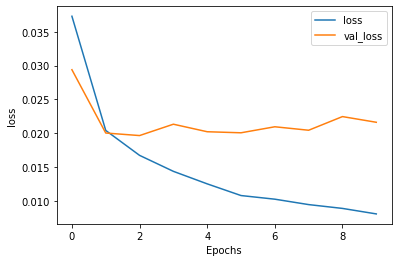

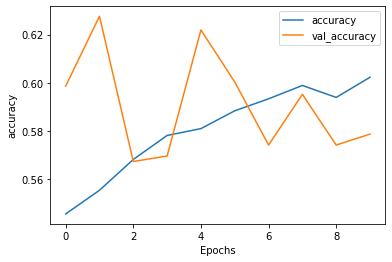

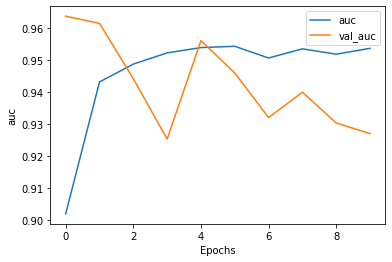

In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(directory+'bert_'+string+'.png')
    plt.show()

for metric in bert_model.metrics_names:
    plot_graphs(history, metric)

# Save Class

In [ ]:
# # add id as new column
# class_df.insert(0, 'id', class_df.index+1)
# class_df.pop('count')
# class_df.pop('weight')
# class_df.columns

In [ ]:
# # save to directory
# directory = 'data/'
# if not os.path.exists(directory):
#     os.mkdir(directory)

# saved_data_path = os.path.join(directory, 'label.csv')
# class_df.to_csv(saved_data_path, index=False)

Learning rate -> Coursera Course<br>
[Model architecture](https://ieeexplore.ieee.org/abstract/document/8723320)<br>
[Layer concatenation](https://keras.io/api/layers/merging_layers/concatenate/)<br>
https://stackoverflow.com/questions/38387913/reason-of-having-high-auc-and-low-accuracy-in-a-balanced-dataset